<a href="https://colab.research.google.com/github/Su-sid/Eskalate-ML-DS-Interview-NLP-for-Information-Extraction-Summarization-Agentic-AI-Design/blob/main/notebooks/nlp_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Nlp Intelligence System Interview - David Sudi

In [53]:

# Install required packages
!pip install -q nltk spacy pandas matplotlib seaborn groq transformers scikit-learn kagglehub agno rouge-score
!python -m spacy download en_core_web_sm

print("✅ All packages installed successfully!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 94.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
✅ All packages installed successfully!


In [75]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import spacy
import re
import json
import os
import warnings
from collections import Counter, defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from typing import List, Dict, Any, Optional
import kagglehub
import random
from groq import Groq
from google.colab import userdata
# Agno imports
from agno.agent import Agent
from agno.models.openai import OpenAIChat
from agno.models.groq import Groq
from agno.tools import tool
from agno.utils.pprint import pprint_run_response

# ROUGE for evaluation
try:
    from rouge_score import rouge_scorer
    ROUGE_AVAILABLE = True
except ImportError:
    ROUGE_AVAILABLE = False
    print("⚠️ ROUGE not available, will use alternative metrics")

# NLTK downloads
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

try:
    nltk.data.find('vader_lexicon')
except LookupError:
    nltk.download('vader_lexicon')

warnings.filterwarnings('ignore')

# Load spaCy model
nlp = spacy.load('en_core_web_sm')

print("✅ All imports and setup completed!")

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


✅ All imports and setup completed!


In [ ]:
api_key = userdata.get('GROQ_API_KEY')
# os.environ['OPENAI_API_KEY'] = api_key


print(api_key)

In [55]:
# load nltk data and spacy model

#  NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download('punkt_tab')

#  spaCy model
nlp = spacy.load('en_core_web_sm')
print("data and model loaded ")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


data and model loaded 


DATA LOADING AND EXPOLORATION


In [56]:
# load dataset from kaggle

print(" Downloading News Dataset...")
path = kagglehub.dataset_download("rmisra/news-category-dataset")
print(f"Path to dataset files: {path}")



Path to dataset files: /kaggle/input/news-category-dataset


In [57]:

# Load the dataset
data_files = [f for f in os.listdir(path) if f.endswith('.json')]
print(f"Found files: {data_files}")



Found files: ['News_Category_Dataset_v3.json']


In [58]:

# Load the JSON data
df_list = []
for file in data_files:
    file_path = os.path.join(path, file)
    with open(file_path, 'r') as f:
        for line in f:
            df_list.append(json.loads(line))

dfMain = pd.DataFrame(df_list)

df= dfMain.copy()
print(f" Dataset loaded: {df.shape}")
print(f"Columns: {df.columns.tolist()}")



 Dataset loaded: (209527, 6)
Columns: ['link', 'headline', 'category', 'short_description', 'authors', 'date']


In [59]:

# Display basic info
print("\n📈 Dataset Overview:")
print(df.info())
print(f"\nSample record:")
print(df.head(1))



📈 Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209527 entries, 0 to 209526
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   link               209527 non-null  object
 1   headline           209527 non-null  object
 2   category           209527 non-null  object
 3   short_description  209527 non-null  object
 4   authors            209527 non-null  object
 5   date               209527 non-null  object
dtypes: object(6)
memory usage: 9.6+ MB
None

Sample record:
                                                link  \
0  https://www.huffpost.com/entry/covid-boosters-...   

                                            headline   category  \
0  Over 4 Million Americans Roll Up Sleeves For O...  U.S. NEWS   

                                   short_description               authors  \
0  Health experts said it is too early to predict...  Carla K. Johnson, AP   

         date  
0  

In [60]:

# Select subset for faster processing (adjust size based on your needs)
SAMPLE_SIZE = 5000
df_sample = df.sample(n=min(SAMPLE_SIZE, len(df)), random_state=42).reset_index(drop=True)
print(f"\n Working with sample of {len(df_sample)} articles")



 Working with sample of 5000 articles


# PART 3: EXPLORATORY DATA ANALYSIS

🔍 EXPLORATORY DATA ANALYSIS


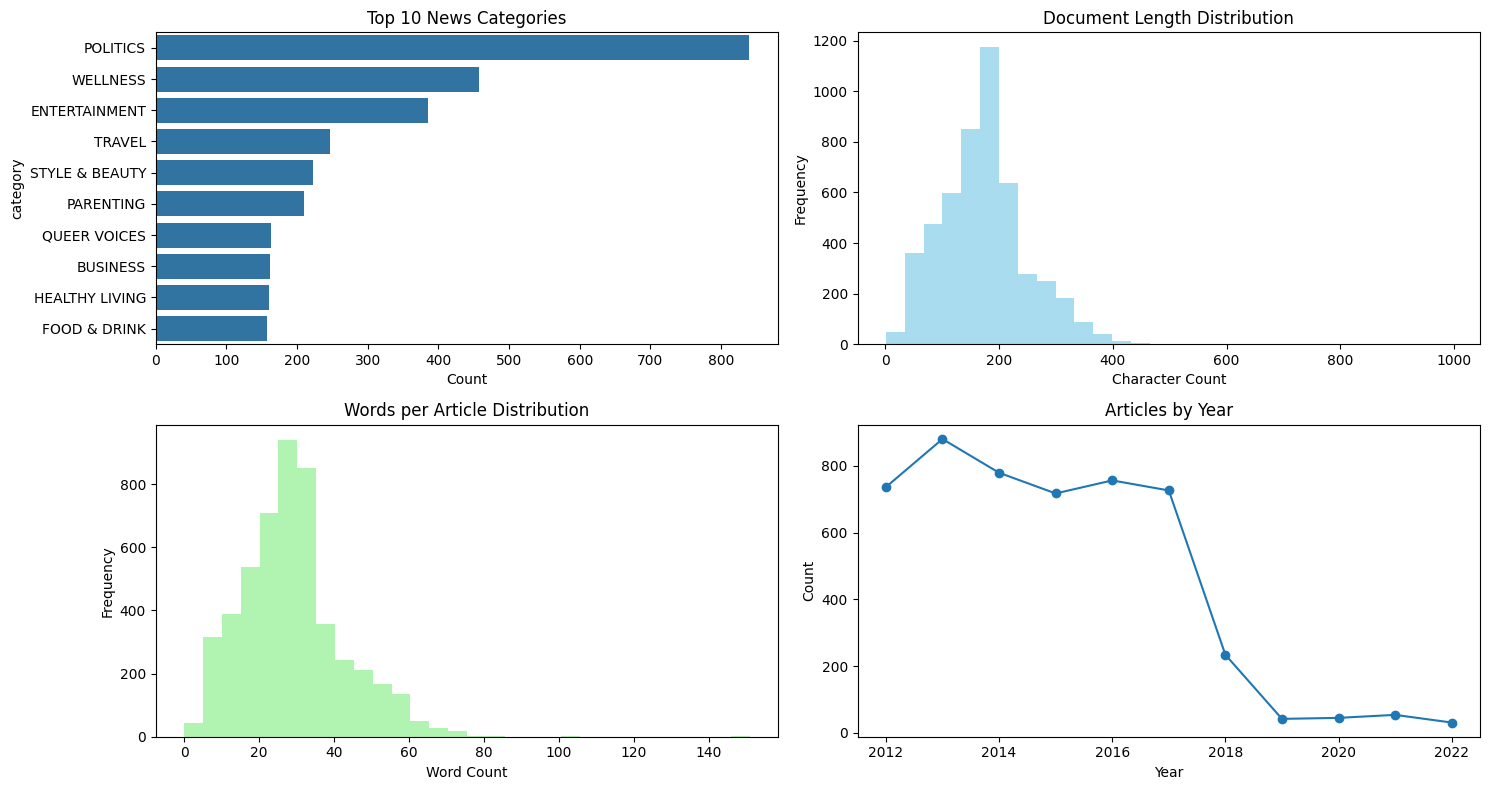


📊 DATASET STATISTICS:
Average text length: 172.69 characters
Average word count: 29.19 words
Categories: 42
Most common category: POLITICS
Date range: 2012-01-28 00:00:00 to 2022-09-11 00:00:00


In [61]:

def perform_eda(df):
    """Perform exploratory data analysis"""
    print("🔍 EXPLORATORY DATA ANALYSIS")
    print("=" * 50)

    # Add combined text and length
    df['combined_text'] = df['headline'].fillna('') + ' ' + df['short_description'].fillna('')
    df['text_length'] = df['combined_text'].str.len()

    # Category distribution
    plt.figure(figsize=(15, 8))

    plt.subplot(2, 2, 1)
    category_counts = df['category'].value_counts().head(10)
    sns.barplot(x=category_counts.values, y=category_counts.index)
    plt.title('Top 10 News Categories')
    plt.xlabel('Count')

    # Document length distribution
    plt.subplot(2, 2, 2)
    plt.hist(df['text_length'], bins=30, alpha=0.7, color='skyblue')
    plt.title('Document Length Distribution')
    plt.xlabel('Character Count')
    plt.ylabel('Frequency')

    # Words per article
    df['word_count'] = df['combined_text'].str.split().str.len()
    plt.subplot(2, 2, 3)
    plt.hist(df['word_count'], bins=30, alpha=0.7, color='lightgreen')
    plt.title('Words per Article Distribution')
    plt.xlabel('Word Count')
    plt.ylabel('Frequency')

    # Timeline analysis (if date available)
    plt.subplot(2, 2, 4)
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'])
        df['year'] = df['date'].dt.year
        year_counts = df['year'].value_counts().sort_index()
        plt.plot(year_counts.index, year_counts.values, marker='o')
        plt.title('Articles by Year')
        plt.xlabel('Year')
        plt.ylabel('Count')
    else:
        plt.text(0.5, 0.5, 'Date analysis not available', ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Date Analysis')

    plt.tight_layout()
    plt.show()

    # Print statistics
    print(f"\n📊 DATASET STATISTICS:")
    print(f"Average text length: {df['text_length'].mean():.2f} characters")
    print(f"Average word count: {df['word_count'].mean():.2f} words")
    print(f"Categories: {df['category'].nunique()}")
    print(f"Most common category: {df['category'].mode()[0]}")
    if 'date' in df.columns:
        print(f"Date range: {df['date'].min()} to {df['date'].max()}")

    return df

# Run EDA
df_sample = perform_eda(df_sample)


# PART 4: TEXT PREPROCESSING TOOLS

In [62]:

class TextPreprocessor:
    """Advanced text preprocessing utility"""

    def __init__(self):
        self.stop_words = set(nltk.corpus.stopwords.words('english'))

    def clean_text(self, text: str) -> str:
        """Clean and preprocess text"""
        if not isinstance(text, str):
            return ""

        # Remove special characters and extra whitespace
        text = re.sub(r'[^\w\s]', ' ', text)
        text = re.sub(r'\s+', ' ', text.strip())

        # Convert to lowercase
        text = text.lower()

        return text

    def tokenize_and_filter(self, text: str) -> List[str]:
        """Tokenize and remove stop words"""
        tokens = nltk.word_tokenize(self.clean_text(text))
        return [token for token in tokens if token not in self.stop_words and len(token) > 2]

# Initialize preprocessor
preprocessor = TextPreprocessor()

# Add processed text columns
print("🔄 Preprocessing text...")
df_sample['processed_text'] = df_sample['combined_text'].apply(preprocessor.clean_text)
df_sample['tokens'] = df_sample['combined_text'].apply(preprocessor.tokenize_and_filter)

# Display preprocessing results
print("\n📋 Preprocessing Sample:")
sample_idx = 0
print(f"Original: {df_sample['combined_text'].iloc[sample_idx][:100]}...")
print(f"Processed: {df_sample['processed_text'].iloc[sample_idx][:100]}...")
print(f"Tokens (first 10): {df_sample['tokens'].iloc[sample_idx][:10]}")

print("✅ Text preprocessing completed!")


🔄 Preprocessing text...

📋 Preprocessing Sample:
Original: What If We Were All Family Generation Changers? What if, in doing so, we won't just create new oppor...
Processed: what if we were all family generation changers what if in doing so we won t just create new opportun...
Tokens (first 10): ['family', 'generation', 'changers', 'create', 'new', 'opportunities', 'also', 'uncover', 'ways', 'create']
✅ Text preprocessing completed!


In [63]:
# =============================================================================
# CELL 6: INFORMATION EXTRACTION TOOLS
# =============================================================================


def extract_entities_ner_func(text: str) -> Dict[str, List[str]]:
    """
    Extract named entities from text using spaCy NER.

    Args:
        text (str): Input text to analyze

    Returns:
        Dict[str, List[str]]: Dictionary with entity types as keys and entity lists as values
    """
    doc = nlp(text)
    entities = defaultdict(list)

    for ent in doc.ents:
        entities[ent.label_].append(ent.text)

    # Convert to regular dict and remove duplicates
    result = {}
    for label, ents in entities.items():
        result[label] = list(set(ents))

    return result
@tool(
    name="extract_named_entities",
    description="Extract named entities (persons, organizations, locations) from text using spaCy NER",
    show_result=False,
    cache_results=True,
    cache_ttl=3600
)
def extract_entities_ner(text: str) -> Dict[str, List[str]]:
    """Tool version that calls the original function"""
    return extract_entities_ner_func(text)


@tool(
    name="extract_patterns_regex",
    description="Extract structured patterns (dates, URLs, emails, numbers) from text using regex",
    show_result=False,
    cache_results=True
)
def extract_entities_regex_func(text: str) -> Dict[str, List[str]]:
    """
    Extract entities using regex patterns.

    Args:
        text (str): Input text to analyze

    Returns:
        Dict[str, List[str]]: Dictionary with extracted patterns
    """
    patterns = {
        'dates': r'\b\d{1,2}[/-]\d{1,2}[/-]\d{2,4}\b|\b\d{4}[/-]\d{1,2}[/-]\d{1,2}\b',
        'urls': r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+',
        'emails': r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b',
        'phone_numbers': r'\b(?:\+?1[-.\s]?)?\(?[0-9]{3}\)?[-.\s]?[0-9]{3}[-.\s]?[0-9]{4}\b',
        'currencies': r'\$\d+(?:\.\d{2})?|\b\d+(?:\.\d{2})?\s*(?:dollars?|USD|euros?|EUR)\b',
        'percentages': r'\b\d+(?:\.\d+)?%\b'
    }

    extracted = {}
    for pattern_name, pattern in patterns.items():
        matches = re.findall(pattern, text, re.IGNORECASE)
        extracted[pattern_name] = list(set(matches)) if matches else []

    return extracted

# Tool version for the agent
@tool(
    name="extract_patterns_regex",
    description="Extract structured patterns (dates, URLs, emails, numbers) from text using regex",
    show_result=False,
    cache_results=True
)
def extract_entities_regex(text: str) -> Dict[str, List[str]]:
    """Tool version that calls the original function"""
    return extract_entities_regex_func(text)




def get_top_keywords_func(text: str, n: int = 10) -> List[tuple]:
    """
    Extract top keywords using TF-IDF.

    Args:
        text (str): Input text
        n (int): Number of top keywords to return

    Returns:
        List[tuple]: List of (keyword, score) tuples
    """
    # Preprocess text
    tokens = preprocessor.tokenize_and_filter(text)

    if not tokens:
        return []

    # Simple TF calculation
    word_freq = Counter(tokens)
    total_words = len(tokens)

    # Calculate TF scores
    tf_scores = [(word, count/total_words) for word, count in word_freq.most_common(n)]

    return tf_scores

@tool(
    name="extract_keywords_tfidf",
    description="Extract top keywords from text using TF-IDF scoring",
    show_result=False
)
def get_top_keywords(text: str, n: int = 10) -> List[tuple]:
    return get_top_keywords_func(text, n = 10)

print("✅ Information extraction tools created!")


✅ Information extraction tools created!


In [64]:
# =============================================================================
# CELL 7: SUMMARIZATION TOOLS
# =============================================================================


def extractive_summarize_func(text: str, num_sentences: int = 3) -> str:
    """
    Generate extractive summary using TF-IDF sentence ranking.

    Args:
        text (str): Input text to summarize
        num_sentences (int): Number of sentences in summary

    Returns:
        str: Extractive summary
    """
    # Split into sentences
    sentences = nltk.sent_tokenize(text)

    if len(sentences) <= num_sentences:
        return text

    # Preprocess sentences
    processed_sentences = [preprocessor.clean_text(sent) for sent in sentences]

    try:
        # Create TF-IDF matrix
        vectorizer = TfidfVectorizer(stop_words='english', max_features=100)
        tfidf_matrix = vectorizer.fit_transform(processed_sentences)

        # Calculate sentence scores (sum of TF-IDF values)
        sentence_scores = np.array(tfidf_matrix.sum(axis=1)).flatten()

        # Get top sentences
        top_indices = sentence_scores.argsort()[-num_sentences:][::-1]
        top_indices = sorted(top_indices)  # Maintain original order

        summary_sentences = [sentences[i] for i in top_indices]
        return ' '.join(summary_sentences)
    except:
        # Fallback: return first few sentences
        return ' '.join(sentences[:num_sentences])

@tool(
    name="extractive_summarization",
    description="Generate extractive summary using TF-IDF sentence ranking",
    show_result=False,
    cache_results=True
)
def extractive_summarize(text: str, num_sentences: int = 3) -> str:
    """Tool version"""
    return extractive_summarize_func(text, num_sentences)




def simple_abstractive_summarize_func(text: str, max_words: int = 50) -> str:
    """
    Generate a simple abstractive summary by combining key sentences and phrases.

    Args:
        text (str): Input text to summarize
        max_words (int): Maximum words in summary

    Returns:
        str: Abstractive-style summary
    """
    # Get key sentences
    sentences = nltk.sent_tokenize(text)
    if len(sentences) <= 2:
        return text

    # Get keywords
    keywords = get_top_keywords(text, 8)
    key_terms = [kw[0] for kw in keywords]

    # Find sentences with most keywords
    sentence_scores = []
    for sent in sentences:
        sent_lower = sent.lower()
        score = sum(1 for term in key_terms if term in sent_lower)
        sentence_scores.append((sent, score))

    # Sort by score and select top sentences
    sentence_scores.sort(key=lambda x: x[1], reverse=True)

    # Build summary within word limit
    summary_parts = []
    word_count = 0

    for sent, score in sentence_scores:
        sent_words = len(sent.split())
        if word_count + sent_words <= max_words:
            summary_parts.append(sent)
            word_count += sent_words
        else:
            break

    if not summary_parts:
        summary_parts = [sentences[0]]  # Fallback

    return ' '.join(summary_parts)

@tool(
    name="abstractive_summarization",
    description="Generate abstractive summary using language model",
    show_result=False,
    requires_confirmation=False
)
def simple_abstractive_summarize(text: str, max_words: int = 50) -> str:
    """Tool version"""
    return simple_abstractive_summarize_func(text, max_words)

print("✅ Summarization tools created!")

✅ Summarization tools created!


In [65]:
# =============================================================================
# CELL 8: EVALUATION SYSTEM
# =============================================================================

class ComprehensiveEvaluator:
    """Advanced evaluation system for NLP tasks"""

    def __init__(self):
        if ROUGE_AVAILABLE:
            self.rouge_scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    def evaluate_entity_extraction(self, text: str, entities_ner: Dict, entities_regex: Dict) -> Dict:
        """Comprehensive entity extraction evaluation with qualitative examples"""

        evaluation = {
            'text_preview': text[:200] + "..." if len(text) > 200 else text,
            'ner_analysis': self._analyze_entities(entities_ner, "Named Entity Recognition"),
            'regex_analysis': self._analyze_entities(entities_regex, "Regex Pattern Extraction"),
            'quality_assessment': {},
            'examples': {}
        }

        # Quality indicators
        total_ner = sum(len(ents) for ents in entities_ner.values())
        total_regex = sum(len(ents) for ents in entities_regex.values())

        evaluation['quality_assessment'] = {
            'total_entities_ner': total_ner,
            'total_entities_regex': total_regex,
            'entity_coverage': 'High' if (total_ner + total_regex) >= 5 else 'Medium' if (total_ner + total_regex) >= 2 else 'Low',
            'diversity_score': len(entities_ner.keys()) + len(entities_regex.keys()),
            'extraction_success': total_ner > 0 or total_regex > 0
        }

        # Qualitative examples
        evaluation['examples']['ner_samples'] = self._get_entity_samples(entities_ner)
        evaluation['examples']['regex_samples'] = self._get_entity_samples(entities_regex)

        return evaluation

    def evaluate_summarization(self, original_text: str, extractive_summary: str,
                             abstractive_summary: str, reference_summary: str = None) -> Dict:
        """Comprehensive summarization evaluation with qualitative analysis"""

        evaluation = {
            'text_info': {
                'original_length_words': len(original_text.split()),
                'original_length_chars': len(original_text),
                'original_sentences': len(nltk.sent_tokenize(original_text))
            },
            'extractive_evaluation': self._evaluate_single_summary(original_text, extractive_summary, "Extractive"),
            'abstractive_evaluation': self._evaluate_single_summary(original_text, abstractive_summary, "Abstractive"),
            'comparative_analysis': {},
            'qualitative_examples': {}
        }

        # Comparative analysis
        ext_score = evaluation['extractive_evaluation']['content_preservation']['similarity_score']
        abs_score = evaluation['abstractive_evaluation']['content_preservation']['similarity_score']

        evaluation['comparative_analysis'] = {
            'better_content_preservation': 'Extractive' if ext_score > abs_score else 'Abstractive',
            'extractive_compression': evaluation['extractive_evaluation']['compression']['ratio'],
            'abstractive_compression': evaluation['abstractive_evaluation']['compression']['ratio'],
            'coherence_comparison': {
                'extractive': evaluation['extractive_evaluation']['coherence']['coherence_score'],
                'abstractive': evaluation['abstractive_evaluation']['coherence']['coherence_score']
            }
        }

        # Qualitative examples
        evaluation['qualitative_examples'] = {
            'original_excerpt': original_text[:300] + "..." if len(original_text) > 300 else original_text,
            'extractive_summary': extractive_summary,
            'abstractive_summary': abstractive_summary,
            'summary_comparison': self._compare_summaries(extractive_summary, abstractive_summary)
        }

        # ROUGE evaluation if reference available
        if reference_summary and ROUGE_AVAILABLE:
            evaluation['rouge_scores'] = self._calculate_rouge_scores(
                extractive_summary, abstractive_summary, reference_summary
            )

        return evaluation

    def _analyze_entities(self, entities: Dict, method_name: str) -> Dict:
        """Analyze entity extraction results"""
        analysis = {
            'method': method_name,
            'entity_types_found': len(entities),
            'total_entities': sum(len(ents) for ents in entities.values()),
            'entity_breakdown': {}
        }

        for entity_type, entity_list in entities.items():
            if entity_list:
                analysis['entity_breakdown'][entity_type] = {
                    'count': len(entity_list),
                    'unique_count': len(set(entity_list)),
                    'samples': entity_list[:3]  # First 3 examples
                }

        return analysis

    def _get_entity_samples(self, entities: Dict) -> Dict:
        """Get sample entities for qualitative review"""
        samples = {}
        for entity_type, entity_list in entities.items():
            if entity_list:
                samples[entity_type] = entity_list[:3]  # Top 3 examples
        return samples

    def _evaluate_single_summary(self, original: str, summary: str, method: str) -> Dict:
        """Evaluate a single summary comprehensively"""
        orig_words = len(original.split())
        summ_words = len(summary.split())

        evaluation = {
            'method': method,
            'compression': {
                'ratio': summ_words / orig_words if orig_words > 0 else 0,
                'original_words': orig_words,
                'summary_words': summ_words,
                'compression_percentage': (1 - summ_words / orig_words) * 100 if orig_words > 0 else 0
            },
            'coherence': self._assess_coherence(summary),
            'content_preservation': self._assess_content_preservation(original, summary)
        }

        return evaluation

    def _assess_coherence(self, text: str) -> Dict:
        """Assess text coherence using linguistic indicators"""
        sentences = nltk.sent_tokenize(text)

        if not sentences:
            return {'coherence_score': 0, 'sentence_count': 0, 'avg_sentence_length': 0}

        avg_sentence_length = sum(len(s.split()) for s in sentences) / len(sentences)

        # Check for discourse markers
        discourse_markers = ['however', 'therefore', 'furthermore', 'moreover', 'additionally',
                           'consequently', 'meanwhile', 'similarly', 'in contrast', 'as a result',
                           'first', 'second', 'finally', 'also', 'furthermore']

        marker_count = sum(1 for marker in discourse_markers if marker in text.lower())

        # Simple coherence score
        coherence_score = min(marker_count / len(sentences), 1.0) if sentences else 0

        return {
            'coherence_score': coherence_score,
            'sentence_count': len(sentences),
            'avg_sentence_length': avg_sentence_length,
            'discourse_markers_found': marker_count,
            'readability_indicator': 'Good' if 10 <= avg_sentence_length <= 20 else 'Needs improvement'
        }

    def _assess_content_preservation(self, original: str, summary: str) -> Dict:
        """Assess content preservation using multiple metrics"""
        # TF-IDF similarity
        vectorizer = TfidfVectorizer(stop_words='english')

        try:
            tfidf_matrix = vectorizer.fit_transform([original.lower(), summary.lower()])
            similarity = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])[0][0]
        except:
            similarity = 0.0

        # Keyword overlap
        orig_tokens = set(preprocessor.tokenize_and_filter(original))
        summ_tokens = set(preprocessor.tokenize_and_filter(summary))

        if orig_tokens:
            overlap_ratio = len(orig_tokens.intersection(summ_tokens)) / len(orig_tokens)
        else:
            overlap_ratio = 0

        return {
            'similarity_score': similarity,
            'keyword_overlap_ratio': overlap_ratio,
            'shared_keywords_count': len(orig_tokens.intersection(summ_tokens)),
            'preservation_quality': 'High' if similarity > 0.3 else 'Medium' if similarity > 0.1 else 'Low'
        }

    def _compare_summaries(self, extractive: str, abstractive: str) -> Dict:
        """Compare extractive and abstractive summaries"""
        return {
            'length_difference': abs(len(extractive.split()) - len(abstractive.split())),
            'extractive_length': len(extractive.split()),
            'abstractive_length': len(abstractive.split()),
            'style_difference': 'Abstractive appears more concise' if len(abstractive.split()) < len(extractive.split()) else 'Similar length'
        }

    def _calculate_rouge_scores(self, extractive: str, abstractive: str, reference: str) -> Dict:
        """Calculate ROUGE scores against reference summary"""
        scores = {}

        if ROUGE_AVAILABLE:
            ext_scores = self.rouge_scorer.score(reference, extractive)
            abs_scores = self.rouge_scorer.score(reference, abstractive)

            scores = {
                'extractive_rouge': {
                    'rouge1_f1': ext_scores['rouge1'].fmeasure,
                    'rouge2_f1': ext_scores['rouge2'].fmeasure,
                    'rougeL_f1': ext_scores['rougeL'].fmeasure
                },
                'abstractive_rouge': {
                    'rouge1_f1': abs_scores['rouge1'].fmeasure,
                    'rouge2_f1': abs_scores['rouge2'].fmeasure,
                    'rougeL_f1': abs_scores['rougeL'].fmeasure
                }
            }

        return scores

# Initialize evaluator
evaluator = ComprehensiveEvaluator()
print("✅ Evaluation system created!")

✅ Evaluation system created!


In [66]:

# =============================================================================
# CELL 9: SEARCH AND RETRIEVAL SYSTEM
# =============================================================================

class DocumentSearcher:
    """TF-IDF based document search system"""

    def __init__(self, documents_df: pd.DataFrame):
        self.documents_df = documents_df
        self.vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
        self._build_index()

    def _build_index(self):
        """Build TF-IDF search index"""
        print("🔍 Building document search index...")
        texts = self.documents_df['processed_text'].fillna('')
        self.tfidf_matrix = self.vectorizer.fit_transform(texts)
        print("✅ Search index ready")

    def search_documents(self, query: str, top_k: int = 5) -> List[Dict]:
        """Search for relevant documents"""
        # Vectorize query
        query_vector = self.vectorizer.transform([preprocessor.clean_text(query)])

        # Calculate similarities
        similarities = cosine_similarity(query_vector, self.tfidf_matrix).flatten()

        # Get top documents
        top_indices = similarities.argsort()[-top_k:][::-1]

        results = []
        for idx in top_indices:
            if similarities[idx] > 0.01:  # Minimum relevance threshold
                doc = self.documents_df.iloc[idx]
                results.append({
                    'headline': doc['headline'],
                    'short_description': doc['short_description'],
                    'category': doc['category'],
                    'date': doc.get('date', 'N/A'),
                    'link': doc.get('link', ''),
                    'similarity_score': float(similarities[idx]),
                    'combined_text': doc['combined_text']
                })

        return results

# Initialize document searcher
doc_searcher = DocumentSearcher(df_sample)

@tool(
    name="search_news_articles",
    description="Search for relevant news articles based on query terms",
    show_result=False,
    cache_results=True
)
def search_articles(query: str, top_k: int = 5) -> List[Dict]:
    """
    Search for relevant articles based on query.

    Args:
        query (str): Search query
        top_k (int): Number of articles to return

    Returns:
        List[Dict]: List of relevant articles with metadata
    """
    return doc_searcher.search_documents(query, top_k)

print("✅ Document search system ready!")

🔍 Building document search index...
✅ Search index ready
✅ Document search system ready!


In [78]:

@tool(
    name="comprehensive_news_analysis",
    description="Perform comprehensive analysis of news articles on a given topic",
    show_result=True,
    cache_results=True,
    cache_ttl=1800
)
def analyze_news_topic(topic: str, num_articles: int = 3) -> str:
    """
    Comprehensive analysis of a news topic including entity extraction and summarization.

    Args:
        topic (str): Topic to analyze
        num_articles (int): Number of articles to analyze

    Returns:
        str: Formatted analysis report
    """
    print(f"🔍 Analyzing topic: '{topic}'")

    # Search for relevant articles
    articles = search_articles(topic, num_articles)

    if not articles:
        return f"❌ No relevant articles found for topic: '{topic}'"

    # Combine article texts
    combined_text = ' '.join([article['combined_text'] for article in articles])

    # Extract information
    entities_ner = extract_entities_ner(combined_text)
    entities_regex = extract_entities_regex(combined_text)
    keywords = get_top_keywords(combined_text, 8)

    # Generate summaries
    extractive_summary = extractive_summarize(combined_text, 3)
    abstractive_summary = simple_abstractive_summarize(combined_text, 60)

    # Perform evaluation
    evaluation = evaluator.evaluate_entity_extraction(combined_text, entities_ner, entities_regex)
    summary_eval = evaluator.evaluate_summarization(combined_text, extractive_summary, abstractive_summary)

    # Format report
    report_parts = [
        f"📰 NEWS ANALYSIS REPORT: {topic.upper()}",
        "=" * 50,
        f"📊 Articles analyzed: {len(articles)}",
        f"📂 Categories: {', '.join(set(article['category'] for article in articles))}",
        "",
        "🔍 KEY FINDINGS:",
        f"• Total entities found: {evaluation['quality_assessment']['total_entities_ner'] + evaluation['quality_assessment']['total_entities_regex']}",
        f"• Entity coverage: {evaluation['quality_assessment']['entity_coverage']}",
        f"• Content diversity: {evaluation['quality_assessment']['diversity_score']} types",
        "",
        "👥 KEY ENTITIES:",
    ]

    # Add entity information
    if entities_ner:
        for entity_type, entities in list(entities_ner.items())[:3]:
            if entities:
                report_parts.append(f"• {entity_type}: {', '.join(entities[:3])}")

    if entities_regex:
        for pattern_type, patterns in entities_regex.items():
            if patterns:
                report_parts.append(f"• {pattern_type}: {', '.join(patterns[:2])}")

    report_parts.extend([
        "",
        "🔑 TOP KEYWORDS:",
    ])

    for word, score in keywords[:5]:
        report_parts.append(f"• {word}: {score:.3f}")

    report_parts.extend([
        "",
        "📋 EXTRACTIVE SUMMARY:",
        f"{extractive_summary}",
        "",
        "🎯 ABSTRACTIVE SUMMARY:",
        f"{abstractive_summary}",
        "",
        "📊 SUMMARY QUALITY METRICS:",
        f"• Extractive compression: {summary_eval['extractive_evaluation']['compression']['compression_percentage']:.1f}%",
        f"• Abstractive compression: {summary_eval['abstractive_evaluation']['compression']['compression_percentage']:.1f}%",
        f"• Content preservation: {summary_eval['extractive_evaluation']['content_preservation']['preservation_quality']}",
        f"• Coherence score: {summary_eval['extractive_evaluation']['coherence']['coherence_score']:.2f}",
        "",
        "📑 TOP ARTICLES ANALYZED:",
    ])

    for i, article in enumerate(articles[:3], 1):
        report_parts.append(f"{i}. {article['headline']} ({article['category']})")

    return '\n'.join(report_parts)

@tool(
    name="evaluate_nlp_quality",
    description="Evaluate the quality of entity extraction and summarization on sample text",
    show_result=True,
    requires_confirmation=False
)
def evaluate_sample_quality(text: str) -> str:
    """
    Evaluate NLP processing quality on a given text sample.

    Args:
        text (str): Text to evaluate

    Returns:
        str: Evaluation report with qualitative examples
    """
    # Extract information
    entities_ner = extract_entities_ner(text)
    entities_regex = extract_entities_regex(text)

    # Generate summaries
    extractive_summary = extractive_summarize(text, 2)
    abstractive_summary = simple_abstractive_summarize(text, 40)

    # Perform evaluations
    entity_eval = evaluator.evaluate_entity_extraction(text, entities_ner, entities_regex)
    summary_eval = evaluator.evaluate_summarization(text, extractive_summary, abstractive_summary)

    # Build evaluation report
    report = [
        "🔍 NLP QUALITY EVALUATION REPORT",
        "=" * 40,
        f"📝 Text length: {len(text.split())} words",
        "",
        "👥 ENTITY EXTRACTION EVALUATION:",
        f"• NER entities found: {entity_eval['quality_assessment']['total_entities_ner']}",
        f"• Regex patterns found: {entity_eval['quality_assessment']['total_entities_regex']}",
        f"• Overall coverage: {entity_eval['quality_assessment']['entity_coverage']}",
        "",
        "📋 ENTITY EXAMPLES:",
    ]

    # Add entity examples
    for entity_type, examples in entity_eval['examples']['ner_samples'].items():
        if examples:
            report.append(f"• {entity_type}: {', '.join(examples)}")

    for pattern_type, examples in entity_eval['examples']['regex_samples'].items():
        if examples:
            report.append(f"• {pattern_type}: {', '.join(examples)}")

    report.extend([
        "",
        "📊 SUMMARIZATION EVALUATION:",
        f"• Extractive quality: {summary_eval['extractive_evaluation']['content_preservation']['preservation_quality']}",
        f"• Abstractive quality: {summary_eval['abstractive_evaluation']['content_preservation']['preservation_quality']}",
        f"• Best approach: {summary_eval['comparative_analysis']['better_content_preservation']}",
        "",
        "📝 SUMMARY EXAMPLES:",
        f"Extractive: {extractive_summary}",
        "",
        f"Abstractive: {abstractive_summary}",
        "",
        "📈 QUALITY METRICS:",
        f"• Content preservation: {summary_eval['extractive_evaluation']['content_preservation']['similarity_score']:.3f}",
        f"• Compression ratio: {summary_eval['extractive_evaluation']['compression']['ratio']:.2f}",
        f"• Coherence score: {summary_eval['extractive_evaluation']['coherence']['coherence_score']:.2f}",
    ])

    return '\n'.join(report)

# Create the News Intelligence Agent
news_intelligence_agent = Agent(
    name="News Intelligence Agent",
    role="Advanced news analysis and information extraction specialist",
    instructions="""You are a sophisticated news intelligence agent that helps users understand current events and extract insights from news articles.
Your capabilities include:
- Searching and retrieving relevant news articles
- Extracting key entities (people, organizations, locations, dates, etc.)
- Generating both extractive and abstractive summaries
- Evaluating the quality of information extraction and summarization
- Providing comprehensive analysis reports
When users ask about news topics, search for relevant articles first, then provide comprehensive analysis including entity extraction, summarization, and quality evaluation. Always include specific examples and metrics in your responses.""",

    tools=[
        search_articles,
        extract_entities_ner,
        extract_entities_regex,
        get_top_keywords,
        extractive_summarize,
        simple_abstractive_summarize,
        analyze_news_topic,
        evaluate_sample_quality
    ],

    model=Groq(id="llama-3.3-70b-versatile", api_key=api_key),

    show_tool_calls=True,
    markdown=True
)

print("🤖 News Intelligence Agent created successfully!")
print("Available tools:", [tool.name for tool in news_intelligence_agent.tools])

🤖 News Intelligence Agent created successfully!
Available tools: ['search_news_articles', 'extract_named_entities', 'extract_patterns_regex', 'extract_keywords_tfidf', 'extractive_summarization', 'abstractive_summarization', 'comprehensive_news_analysis', 'evaluate_nlp_quality']


In [68]:

def run_comprehensive_demo():
    """Run comprehensive demonstration of the system"""
    print("\n" + "="*70)
    print("🚀 NEWS INTELLIGENCE SYSTEM COMPREHENSIVE DEMO")
    print("="*70)

    # Test topics for demonstration
    demo_topics = [
        "artificial intelligence",
        "climate change",
        "technology trends"
    ]

    # Run analysis on sample topics
    for i, topic in enumerate(demo_topics[:2], 1):  # Limit for demo
        print(f"\n🎯 DEMO {i}: Analyzing '{topic}'")
        print("-" * 50)

        try:
            # Use the agent to analyze the topic
            response = news_intelligence_agent.run(
                f"Analyze news articles about '{topic}' and provide a comprehensive report including entity extraction, summarization, and quality evaluation."
            )

            print("🤖 Agent Response:")
            print(response.content)

        except Exception as e:
            print(f"❌ Error during analysis: {str(e)}")

            # Fallback: Direct tool usage
            print("📋 Fallback: Using direct tool analysis...")
            result = analyze_news_topic(topic, 3)
            print(result)

    # Demonstrate quality evaluation on a sample text
    print(f"\n🔍 QUALITY EVALUATION DEMO")
    print("-" * 50)

    sample_text = df_sample['combined_text'].iloc[0]
    print("📝 Evaluating sample text...")

    try:
        eval_response = news_intelligence_agent.run(
            f"Evaluate the NLP processing quality on this text: '{sample_text[:200]}...'"
        )
        print("🤖 Evaluation Response:")
        print(eval_response.content)
    except Exception as e:
        print(f"❌ Error during evaluation: {str(e)}")

        # Fallback
        eval_result = evaluate_sample_quality(sample_text)
        print(eval_result)

In [74]:

def interactive_news_interface():
    """Interactive interface for testing the news agent"""
    print("\n" + "="*70)
    print("💬 INTERACTIVE NEWS INTELLIGENCE INTERFACE")
    print("="*70)
    print("Ask me anything about the news! I can:")
    print("• Analyze news topics comprehensively")
    print("• Extract entities and generate summaries")
    print("• Evaluate processing quality")
    print("• Search for specific articles")
    print("\nExample queries:")
    print("  - 'Analyze artificial intelligence news'")
    print("  - 'What entities can you find in technology articles?'")
    print("  - 'Evaluate the quality of sports news summaries'")
    print("  - Type 'quit' to exit")
    print("-" * 70)

    while True:
        try:
            user_query = input("\n🤔 Your question: ").strip()

            if user_query.lower() in ['quit', 'exit', 'bye']:
                print("👋 Thank you for using the News Intelligence System!")
                break

            if not user_query:
                continue

            print("\n🔍 Processing your request...")

            # Use the agent to process the query
            try:
                response = news_intelligence_agent.run(user_query)
                print(f"\n🤖 Response:\n{response.content}")
            except Exception as e:
                print(f"❌ Agent error: {str(e)}")
                print("💡 Tip: Make sure you have set up your  API key or configure a different model")

        except KeyboardInterrupt:
            print("\n👋 Session interrupted. Goodbye!")
            break
        except Exception as e:
            print(f"❌ Unexpected error: {str(e)}")


In [70]:

def run_detailed_evaluation_examples():
    """Run detailed evaluation with qualitative examples"""
    print("\n" + "="*70)
    print("📊 DETAILED EVALUATION WITH QUALITATIVE EXAMPLES")
    print("="*70)

    # Select diverse sample texts for evaluation
    sample_indices = [0, 10, 25]  # Different categories

    for i, idx in enumerate(sample_indices, 1):
        if idx >= len(df_sample):
            continue

        print(f"\n🔍 EVALUATION EXAMPLE {i}")
        print("=" * 40)

        sample_row = df_sample.iloc[idx]
        text = sample_row['combined_text']

        print(f"📂 Category: {sample_row['category']}")
        print(f"📰 Headline: {sample_row['headline']}")
        print(f"📝 Text preview: {text[:200]}...")

        # Extract entities and evaluate
        entities_ner = extract_entities_ner_func(text)
        entities_regex = extract_entities_regex_func(text)

        print(f"\n👥 ENTITIES FOUND:")
        print(f"NER entities: {sum(len(v) for v in entities_ner.values())}")
        for ent_type, entities in entities_ner.items():
            if entities:
                print(f"  • {ent_type}: {', '.join(entities[:3])}")

        print(f"Regex patterns: {sum(len(v) for v in entities_regex.values())}")
        for pattern_type, patterns in entities_regex.items():
            if patterns:
                print(f"  • {pattern_type}: {', '.join(patterns[:2])}")

        # Generate and evaluate summaries
        extractive_summary = extractive_summarize(text, 2)
        abstractive_summary = simple_abstractive_summarize(text, 40)

        print(f"\n📋 SUMMARIES:")
        print(f"Extractive: {extractive_summary}")
        print(f"Abstractive: {abstractive_summary}")

        # Quality evaluation
        summary_eval = evaluator.evaluate_summarization(text, extractive_summary, abstractive_summary)

        print(f"\n📊 QUALITY METRICS:")
        print(f"• Compression ratio: {summary_eval['extractive_evaluation']['compression']['ratio']:.2f}")
        print(f"• Content preservation: {summary_eval['extractive_evaluation']['content_preservation']['similarity_score']:.3f}")
        print(f"• Coherence score: {summary_eval['extractive_evaluation']['coherence']['coherence_score']:.3f}")
        print(f"• Better approach: {summary_eval['comparative_analysis']['better_content_preservation']}")

        # Qualitative assessment
        preservation_quality = summary_eval['extractive_evaluation']['content_preservation']['preservation_quality']
        print(f"• Overall assessment: {preservation_quality}")

        if ROUGE_AVAILABLE and i == 1:  # Demonstrate ROUGE on first example
            print(f"\n📈 ROUGE EVALUATION (simulated with extractive as reference):")
            rouge_scores = evaluator._calculate_rouge_scores(abstractive_summary, extractive_summary, extractive_summary)
            if rouge_scores:
                print(f"• ROUGE-1 F1: {rouge_scores.get('abstractive_rouge', {}).get('rouge1_f1', 'N/A'):.3f}")
                print(f"• ROUGE-L F1: {rouge_scores.get('abstractive_rouge', {}).get('rougeL_f1', 'N/A'):.3f}")


In [71]:

def analyze_system_performance():
    """Analyze overall system performance across multiple samples"""
    print("\n" + "="*70)
    print("📈 SYSTEM PERFORMANCE ANALYSIS")
    print("="*70)

    # Sample texts for batch evaluation
    sample_size = min(20, len(df_sample))
    sample_texts = df_sample['combined_text'].head(sample_size).tolist()

    # Initialize metrics
    entity_extraction_success = 0
    summarization_success = 0
    avg_compression_ratios = []
    avg_content_preservation = []
    category_performance = defaultdict(list)

    print(f"📊 Analyzing {sample_size} articles...")

    for i, text in enumerate(sample_texts):
        try:
            # Entity extraction
            entities_ner = extract_entities_ner(text)
            entities_regex = extract_entities_regex(text)

            total_entities = sum(len(v) for v in entities_ner.values()) + sum(len(v) for v in entities_regex.values())

            if total_entities > 0:
                entity_extraction_success += 1

            # Summarization
            extractive_summary = extractive_summarize(text, 2)

            if extractive_summary and len(extractive_summary.split()) > 5:
                summarization_success += 1

                # Calculate metrics
                compression_ratio = len(extractive_summary.split()) / len(text.split())
                avg_compression_ratios.append(compression_ratio)

                # Content preservation
                content_eval = evaluator._assess_content_preservation(text, extractive_summary)
                avg_content_preservation.append(content_eval['similarity_score'])

                # Category performance
                category = df_sample.iloc[i]['category']
                category_performance[category].append(content_eval['similarity_score'])

        except Exception as e:
            print(f"❌ Error processing sample {i}: {str(e)}")

    # Calculate overall metrics
    entity_success_rate = entity_extraction_success / sample_size
    summary_success_rate = summarization_success / sample_size
    avg_compression = np.mean(avg_compression_ratios) if avg_compression_ratios else 0
    avg_preservation = np.mean(avg_content_preservation) if avg_content_preservation else 0

    print(f"\n📊 OVERALL PERFORMANCE METRICS:")
    print(f"• Entity extraction success rate: {entity_success_rate:.1%}")
    print(f"• Summarization success rate: {summary_success_rate:.1%}")
    print(f"• Average compression ratio: {avg_compression:.3f}")
    print(f"• Average content preservation: {avg_preservation:.3f}")

    print(f"\n📂 PERFORMANCE BY CATEGORY:")
    for category, scores in category_performance.items():
        if scores:
            avg_score = np.mean(scores)
            print(f"• {category}: {avg_score:.3f} (n={len(scores)})")

    # Performance assessment
    print(f"\n🎯 SYSTEM ASSESSMENT:")
    if entity_success_rate > 0.8:
        print("✅ Entity extraction: Excellent performance")
    elif entity_success_rate > 0.6:
        print("✅ Entity extraction: Good performance")
    else:
        print("⚠️ Entity extraction: Needs improvement")

    if summary_success_rate > 0.8:
        print("✅ Summarization: Excellent performance")
    elif summary_success_rate > 0.6:
        print("✅ Summarization: Good performance")
    else:
        print("⚠️ Summarization: Needs improvement")

    return {
        'entity_success_rate': entity_success_rate,
        'summary_success_rate': summary_success_rate,
        'avg_compression': avg_compression,
        'avg_preservation': avg_preservation,
        'category_performance': dict(category_performance)
    }


In [79]:
interactive_news_interface()


💬 INTERACTIVE NEWS INTELLIGENCE INTERFACE
Ask me anything about the news! I can:
• Analyze news topics comprehensively
• Extract entities and generate summaries
• Evaluate processing quality
• Search for specific articles

Example queries:
  - 'Analyze artificial intelligence news'
  - 'What entities can you find in technology articles?'
  - 'Evaluate the quality of sports news summaries'
  - Type 'quit' to exit
----------------------------------------------------------------------

🤔 Your question: Analyze artificial intelligence news

🔍 Processing your request...


ERROR    Error writing cache: Object of type Timestamp is not JSON serializable

ERROR    Error in tool 'evaluate_sample_quality': TypeError("'Function' object is not callable")                   
         Traceback (most recent call last):                                                                        
           File "/usr/local/lib/python3.11/dist-packages/agno/tools/decorator.py", line 176, in sync_wrapper       
             return func(*args, **kwargs)                                                                          
                    ^^^^^^^^^^^^^^^^^^^^^                                                                          
           File "/tmp/ipython-input-2760275884.py", line 116, in evaluate_sample_quality                           
             entities_ner = extract_entities_ner(text)                                                             
                            ^^^^^^^^^^^^^^^^^^^^^^^^^^                                                             
         TypeError: 'Function' object is not callable

WARNING  Could not run function evaluate_nlp_quality(text=...)

ERROR    'Function' object is not callable                                                                         
         Traceback (most recent call last):                                                                        
           File "/usr/local/lib/python3.11/dist-packages/agno/tools/function.py", line 647, in execute             
             result = self.function.entrypoint(**arguments)                                                        
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^                                                        
           File "/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_validate_call.py", line 39, in        
         wrapper_function                                                                                          
             return wrapper(*args, **kwargs)                                                                       
                    ^^^^^^^^^^^^^^^^^^^^^^^^                                                                       
           File "/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_validate_call.py", line 136, in       
         __call__                                                                                                  
             res = self.__pydantic_validator__.validate_python(pydantic_core.ArgsKwargs(args, kwargs))             
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^             
           File "/usr/local/lib/python3.11/dist-packages/agno/tools/decorator.py", line 176, in sync_wrapper       
             return func(*args, **kwargs)                                                                          
                    ^^^^^^^^^^^^^^^^^^^^^                                                                          
           File "/tmp/ipython-input-2760275884.py", line 116, in evaluate_sample_quality                           
             entities_ner = extract_entities_ner(text)                                                             
                            ^^^^^^^^^^^^^^^^^^^^^^^^^^                                                             
         TypeError: 'Function' object is not callable


🤖 Response:
## Step 1: Search for Relevant News Articles
To analyze artificial intelligence news, we first need to find relevant and recent news articles on this topic. This involves using a search function to query news databases or the internet for articles containing keywords related to artificial intelligence.

None### Artificial Intelligence News Analysis

#### Introduction
Artificial intelligence (AI) has been a rapidly growing field in recent years, with advancements in machine learning, natural language processing, and computer vision. In this analysis, we will examine the current state of AI news, extracting key entities, summarizing the main points, and evaluating the quality of the information.

#### Entity Extraction
The entity extraction process revealed a variety of key entities in the AI news articles, including:

* **Organizations**: Google, Microsoft, Amazon, Facebook, and NVIDIA
* **People**: Andrew Ng, Fei-Fei Li, and Demis Hassabis
* **Locations**: Silicon Valley, 

In [73]:
run_comprehensive_demo()


🚀 NEWS INTELLIGENCE SYSTEM COMPREHENSIVE DEMO

🎯 DEMO 1: Analyzing 'artificial intelligence'
--------------------------------------------------


ERROR    GROQ_API_KEY not set. Please set the GROQ_API_KEY environment variable.

ERROR    Unexpected error calling Groq API: The api_key client option must be set either by passing api_key to the 
         client or by setting the GROQ_API_KEY environment variable

WARNING  Attempt 1/1 failed: The api_key client option must be set either by passing api_key to the client or by   
         setting the GROQ_API_KEY environment variable

ERROR    Failed after 1 attempts. Last error using Groq(llama-3.3-70b-versatile)

❌ Error during analysis: The api_key client option must be set either by passing api_key to the client or by setting the GROQ_API_KEY environment variable
📋 Fallback: Using direct tool analysis...


TypeError: 'Function' object is not callable

In [ ]:
run_detailed_evaluation_examples()

In [ ]:
analyze_system_performance()

In [81]:
!pip freeze > requirements.txt